# Decision Trees and Random Forest

## Decision Trees

### Motivating Decision Trees

Decision trees are extremely intuitive ways of classifying data: you simply ask a series of questions in order to close in on the class label. For example, if you're into value investing, you might think of the following scheme to decide whether you invest into a certain stock or not:

<img src="Graphics/0210_DecisionTreeTeX.png" alt="DT_TeX" style="width: 1000px;"/>

(P/B = Price/Book ratio, P/E = Price/Earnings ratio, PEG = Price/Earnings to growth ratio, E = Equity, D = Debt).

Sources tell me this scheme is not Warren Buffet's key to success - it is obviously an overly simplified illustration. But it serves well to demonstrate the idea behind decision trees in ML. The binary splits narrow down the options. The big question here though is of course what questions we ought to ask and in what sequence. This we will discuss in the next sections - first intuitively and then in more rigorous terms.

### Simple Decision Trees Illustrated

To draw up a simple decision tree, we follow these two steps (James et al. (2013)): 
* Divide the predictor space (set of possible values for $X_1, X_2, \ldots, X_p$) into $M$ distinct and non-overlapping regions $R_1, R_2, \ldots, R_M$. 
* For every observation in $R_m$ we model the response as a constant. This constant is based on a majority vote among the observation in $R_m$. 

Let us illustrate this on a two dimensional data set with features $X_1$ and $X_2$. The color of the dots indicate the class label. 

<img src="Graphics/0210_DTScatter.png" alt="DT_Scatter" style="width: 1000px;"/>

Without any split, we have but one region. A decision tree now splits the regions iteratively into predictor spaces $R_m$. This is shown below. The first figure on the left has two spaces, $R_1, R_2$, The second already has four ($R_1, R_2, R_3, R_4$) etc.. The background color indicates the label that the model would assign to a new data point in the respective area. Note that (as in the introductory decision tree figure) each branch can have a sperate number of splits. Some nodes are purer (get split more) than others. 

The `depth=n` argument in the figure title refers to the depth of the tree. Nodes that contain only a single class (color) are not further split. All others will be further split until a stopping criterion is reached, e.g. 
* all predictor spaces are pure (contain only one class), 
* all predictor spaces contain a limited number of points,
* we limit the number of splits through the `depth` argument etc.

<img src="Graphics/0210_DTSplits.png" alt="DT_Splits" style="width: 1000px;"/>

### Mathematical Description
#### Maximizing Information Gain

How do we construct the regions $R_1, \ldots, R_M$? Or put in other words: How do we decide on the splitting variables (i.e. $X_1, X_2, \ldots, X_p$), split points and what topology (shape) the tree should have? To explain this we focus on the CART (classification and regression tree) approach of decision trees as implemented in Scikit-learn. 

In order to describe the mathematics let us assume we have a data set with $p$ inputs for each of the $N$ observations: $(x_i, y_i)$ for $i = 1, 2, \ldots, N$, with $x_i = (x_{i1}, x_{i2}, \ldots, x_{ip})$. 

Most libraries (including Scikit-learn) have implemented binary decision trees, meaning that each node is split into two child nodes. Hence for binary splits at node $m$ we take initial region $R_m$ and select $j$ (of feature $X_j$) and threshold $t_m$ such that the resulting two half-planes 

$$\begin{equation}
R_{\text{left}}(R_m; j, t_m) = \{(X, y) \, | \, X_j < t_m \} \qquad \text{and} \qquad R_{\text{right}}(R_m; j, t_m) = \{(X, y) \, | \, X_j \geq t_m \}
\end{equation}$$

maximize the **information gain ($G$)** for any value of $j$ and $t_m$. 

Let us define $\theta = (j, t_m)$ to simplify expressions. Given $R_m$ with $N_m$ being the total number of samples in $R_m$ and $n_{\text{left}}$, $n_{\text{right}}$ the number samples in the left ($R_{\text{left}}$) and right ($R_{\text{right}}$) child nodes, respectively, the information gain function $G$ is defined as 

$$\begin{equation}
G(R_m; \theta) = H(R_m) - \frac{n_{\text{left}}}{N_m} H(R_{\text{left}}) - \frac{n_{\text{right}}}{N_m} H(R_{\text{right}})
\end{equation}$$

Here, $H()$ is simply a measure of impurity which we'll get to shortly. With that, the information gain $G$ is simply the difference between the impurity of the parent node and the sum of the child node impurities. The lower the impurity of the child nodes, the larger information gain we get (Raschka (2015)).

Our optimization task can therefore be formulated as to find parameter $\theta$ that maximizes the following expression at every node $m$:

$$\begin{equation}
\theta^* = \arg \max_{\theta} G(R_m, \theta)
\end{equation}$$

This is done recursively for every node until the stopping criteria is reached (max. depth, max. number of samples in region etc.; see above).

#### Impurity Measures for Classification Trees

There are three common impurity measures (or splitting criteria), of which only the latter two are recommended for growing decision trees: Classification error rate ($H_E$), Gini index ($H_G$), cross-entropy ($H_H$). To discuss them, let us first define the proportion of class $k$ observations in node $m$ (Friedman et al. (2001)):

$$\begin{equation}
\hat{p}_{mk} = \frac{1}{N_m} \sum_{x_i \in R_m} I(y_i = k)
\end{equation}$$

Earlier we mentioned that all observations in region $R_j$ are assigned to the same class following a majority vote. In more formal terms this means that observations in node $m$ are classified to class $k$ for which $k(m) = \arg \max_k \hat{p}_{mk}$. 

Now, the impurity measures are defined as follows:

$$\begin{align}
&\text{Classification Error rate: } & H_E(R_m) &= 1 - \max_k (p_{mk}) \\
&\text{Gini Index: } & H_G(R_m) &= \sum_k p_{mk} (1 - p_{mk}) \\
&\text{Cross-Entropy: } & H_E(R_m) &= - \sum_k p_{mk} \, \log(p_{mk})
\end{align}$$

Note that for binary classification tasks (e.g. $y \in \{0, 1\}$), $\log$ in the cross-entropy is usually the [logarithm to the base 2.](https://stackoverflow.com/questions/1859554/what-is-entropy-and-information-gain)

Below figure graphs the three impurity measures with respect to $p$. As mentioned, the classification error rate should not be used as an impurity measure. In practice it is primarily used to prune a tree - a concept we will not discuss here. Cross-entropy is minimal if all samples at a node belong to the same class and maximal if we have a uniform distribution among the classes. Therefore, cross-entropy can be understood as a criterion that attempts to maximize the mutual information in the tree. The Gini-index on the other hand works towards minimizing the probability of misclassification. Similar to entropy it is maximal if classes are evenly distributed and minimal if the vast majority of samples belong to the same class. 

In practice both Gini index as well as cross-entropy usually produce similar results and thus it is not advisable to spend much time on evaluating trees using different impurity criteria (Raschka (2015)).

<img src="Graphics/0210_ImpurityIndex.png" alt="ImpurityIndex" style="width: 1500px;"/>

### Advantages and Disadvantages of Decision Trees

Decision trees have several advantages over the other classification approaches discussed so far:

* Intuition is easy to explain
* Trees can be displayed graphically and are easily interpreted even by a layperson
* Trees handle quantitative as well as qualitative features; there's no need to scale the values
* Some people argue that decision trees mirror human thinking very closely, moreso than other approaches.

However, simple decision trees have also disadvantages, some of them are significant:
* Instability of trees/high variance: Small changes in the data often result in very different series of splits
* Decision trees tend to build complex decision boundaries, which often results in overfitting the data
* Low level of predictive accuracy compared other classification approaches discussed in this course.

### Decision Trees in Python

To show how decision trees are applied in Python we once again rely on functions implemented in the Scikit-learn package. This time we will use the `Carseats` data set. It is again a data set that corresponds to James et al. (2013)'s book and contains information on child carseat sales at 400 different stores. `Sales` is the response variable with number of sold units in thousands. All other values are used as features. A detailed description of the data set can be found [here](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf). 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('Data/Carseats.csv')
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


Let us assume you are a financial consultant and work on a market study that discusses appropriate sales channels for child car seats. You know that your client's strategy is to grow the business. Furthermore you learned that to run sales at break even at a sales location the company needs to sell approximately 4'000 units. What feature drives sales and in which stores would you advise your client to offer their product? Here a decision tree helps very much in visualizing the sales driver. 

Before we implement the model we prepare the data. Notice that decision trees are invariant to scaling meaning we could, but don't have to scale values. This is true for both quantitative as well as categorical variables. What we need to do though, is transforming categorical values `ShelveLoc, Urban` and `US` into numeric values. We will use pandas `map` method to (a) show an alternative to `pd.factorize` introduced in previous chapters and (b) ensure a mapping that does not confuse (`pd.factorize()` maps a column's first entry to value 0, second to 1 etc. This would mean that `pd.factorize()` would label `Yes` in columns `Urban` or `US` as 0. Yet `Yes` is predominantly represented by a 1. Therefore, with the `map` function we preclude any confusion).

In [2]:
# Create 'BreakEven' column with 1 if Sales >= 4k, else 0
df['BreakEven'] = df.Sales.map(lambda x: 1 if x>=4 else 0)

# Replace category names with numbers
df.ShelveLoc = df.ShelveLoc.map({'Bad':0, 'Medium': 1, 'Good': 2})
df.Urban     = df.Urban.map({'No':0, 'Yes':1})
df.US        = df.US.map({'No':0, 'Yes':1})
print(df.head(3))

   Sales  CompPrice  Income  Advertising  Population  Price  ShelveLoc  Age  \
0   9.50        138      73           11         276    120          0   42   
1  11.22        111      48           16         260     83          2   65   
2  10.06        113      35           10         269     80          1   59   

   Education  Urban  US  BreakEven  
0         17      1   1          1  
1         10      1   1          1  
2         12      1   1          1  


In [3]:
# Assign features & response to X and y, respectively
X = df.drop(['Sales', 'BreakEven'], axis=1)
y = df.BreakEven

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Now we are in a position to run the `DecisionTreeClassifier`.

In [4]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Creating a decision tree is as simple as that. From the above output we see that per default the function will use the Gini index as criterion. The only argument we set is the maximal depth. Alternatively we could define the maximum tree nodes, the minimum number of samples required to split an internal node or the minimum number of samples required to be at a leaf node. There are more options and it is best to check the [documentation page](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) to get a thorough understanding of the available options. 

As with all other Scikit-learn functions, we can again call the usual performance metrics. The interpretation is as discussed in chapter 8.

In [5]:
# Load metrics sublibrary
from sklearn import metrics

# Print performance metrics
print('True proportion of sales >= 4k: ', y.sum() / y.shape[0])
print('Train score: ', tree.score(X_train, y_train))
print('Test score: ', tree.score(X_test, y_test))
print(37*'-')

# Confusion matrix
y_pred = tree.predict(X_test)
print('Confusion matrix: \n', 
      metrics.confusion_matrix(y_test, y_pred))

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted sales >=4k': y_pred,
                      'True sales >=4k': y_test})
confm.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)
print(confm.groupby(['True sales >=4k','Predicted sales >=4k']).size().unstack('Predicted sales >=4k'))

True proportion of sales >= 4k:  0.91
Train score:  0.94375
Test score:  0.8875
-------------------------------------
Confusion matrix: 
 [[ 0  4]
 [ 5 71]]
Predicted sales >=4k   No   Yes
True sales >=4k                
No                    NaN   4.0
Yes                   5.0  71.0


### Visualizing Decision Trees

Unfortunately, neither `matplotlib` nor `sklearn` have a plotting function integrated to visualize decision trees. However, with the help of additional libraries/packages, Python is able to create a decision tree figure detailing each decision step. To plot these decision trees, we have to rely on third party software. Getting things to run as expected have (at least in my case) proven to be a rather cumbersome experience. To spare you this experience, follow these steps:

* Download and install Graphviz from [the web](http://www.graphviz.org/download/). Mac users select the `.pkg` file corresponding to your system version (Snow Leopard, Lion etc.). Windows users select the `.msi` file. Run the execution file and follow the instructions.
* Type in `!pip list` into an input field. This will list all installed Python packages (and version). Check if you have a package called `graphviz`. If yes, proceed with next step. If not, type `pip install graphviz` into a new command line. This should install the needed Python package.

In [6]:
!pip list

alabaster (0.7.10)
anaconda-client (1.6.5)
anaconda-navigator (1.6.8)
anaconda-project (0.8.0)
asn1crypto (0.22.0)
astroid (1.5.3)
astropy (2.0.2)
babel (2.5.0)
backports.shutil-get-terminal-size (1.0.0)
beautifulsoup4 (4.6.0)
bitarray (0.8.1)
bkcharts (0.2)
blaze (0.11.3)
bleach (2.0.0)
bokeh (0.12.7)
boto (2.48.0)
Bottleneck (1.2.1)
CacheControl (0.12.3)
certifi (2017.7.27.1)
cffi (1.10.0)
chardet (3.0.4)
click (6.7)
cloudpickle (0.4.0)
clyent (1.2.2)
colorama (0.3.9)
comtypes (1.1.2)
conda (4.3.29)
conda-build (3.0.22)
conda-verify (2.0.0)
contextlib2 (0.5.5)
cryptography (2.0.3)
cycler (0.10.0)
Cython (0.26.1)
cytoolz (0.8.2)
dask (0.15.2)
datashape (0.5.4)
decorator (4.1.2)
distlib (0.2.5)
distributed (1.18.3)
docutils (0.14)
entrypoints (0.2.3)
et-xmlfile (1.0.1)
fastcache (1.0.2)
filelock (2.0.12)
Flask (0.12.2)
Flask-Cors (3.0.3)
gevent (1.2.2)
glob2 (0.5)
graphviz (0.8.1)
greenlet (0.4.12)
h5py (2.7.0)
heapdict (1.0.0)
html5lib (0.999999999)
idna (2.6)
imageio (2.2.0)
imagesiz

DEPRECATION: The default format will switch to columns in the future. You can use --format=(legacy|columns) (or define a format=(legacy|columns) in your pip.conf under the [list] section) to disable this warning.


* Finally, we need to make sure that Graphviz' `.exe` file was added to your system `PATH` ([This is an environmental variable that tells the computer which directories to search for executable files (i.e., ready-to-run programs) in response to commands issued by a user](http://www.linfo.org/path_env_var.html)). How do you know if Graphviz is on your `PATH`? Run below code to find out. (Alternatively you might open a shell window and on Windows call `$env:path.split(";")` or on a Mac `echo $PATH$`).

In [16]:
# On a Windows PC (--> remove # to have output)
%echo %PATH%'

# On a Mac
#%echo $PATH

C:\Program Files\ImageMagick-7.0.5-Q16;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\Program Files\MiKTeX 2.9\miktex\bin\x64\;C:\Program Files\Git\cmd;C:\Anaconda;C:\Anaconda\Library\mingw-w64\bin;C:\Anaconda\Library\usr\bin;C:\Anaconda\Library\bin;C:\Anaconda\Scripts;C:\Users\Ben Zimmermann\AppData\Local\Microsoft\WindowsApps;C:\Users\Ben Zimmermann\AppData\Local\GitHubDesktop\bin;C:\Program Files (x86)\Graphviz2.38\bin;;%USERPROFILE%\AppData\Local\Microsoft\WindowsApps'


* You see that in my case, Graphviz2.38 is the last entry on the list. In case it is missing on your machine, add graphviz to the `PATH`, by following the steps described [in this discussion on StackOverflow](https://stackoverflow.com/questions/18438997/why-is-pydot-unable-to-find-graphvizs-executables-in-windows-8). But be careful: This might cause some problems in the background with the Spyder IDE ([see discussion here](https://github.com/ContinuumIO/anaconda-issues/issues/1666)).

Having sorted this Graphviz installation out, we are now able to proceed with plotting the decision tree. Of the function's available input arguments, `filled=True, rounded=True, class_names=['Loss', 'BrEven']` and `feature_names=X.columns.values` are optional but help in making the image visually more appealing by adding color, rounded box edges, showing the class labels counts at each node, and displaying the feature name according to the majority vote at the respective node. The plot below helps understand this.

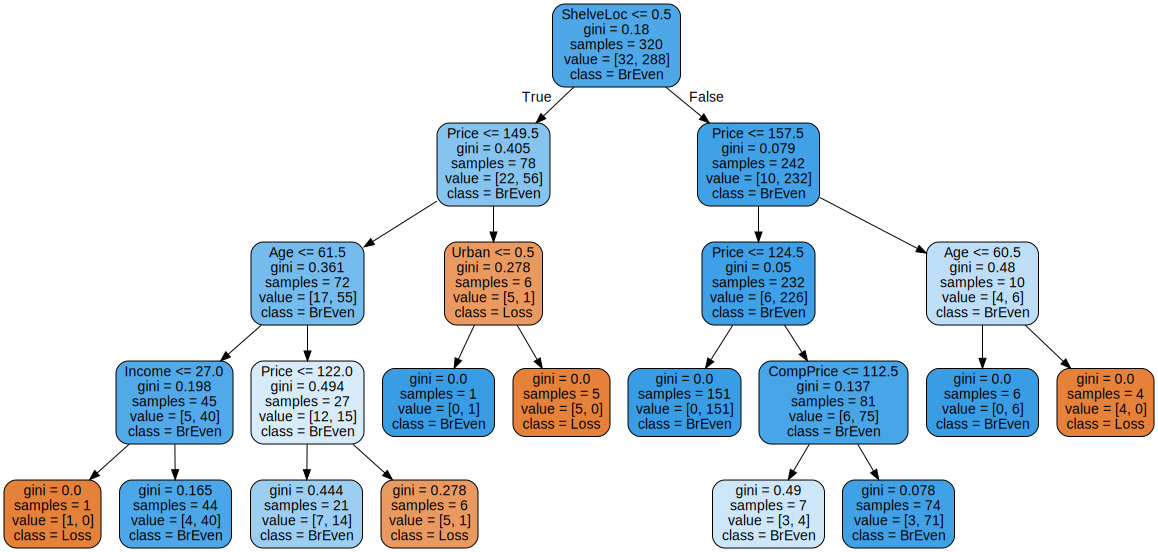

In [8]:
import graphviz
from sklearn.tree import export_graphviz

# Create decision tree object
dot_data = export_graphviz(tree, filled=True, rounded=True,
                           class_names=['Loss', 'BrEven'],
                           feature_names=X.columns.values, 
                           out_file=None)

# Visualize/Plot graph
graph = graphviz.Source(dot_data)  
graph

The above decision tree plot helps us understand how the algorithm decides on a class. The coloring indicates the label. What we learn is that the driving factor for the given training set is in the shelve location and after that the product's selling price. If the shelve location is 0 (bad) we end up in the left side of the tree. Is the shelve location medium or good we run through the right hand side. `Gini` represents the resulting Gini index at that node, `samples` is the number of observations that end up in the respective node, `values` indicates the true label, e.g. 2nd node from the bottom-left `[4, 40]` means of the 44 samples 4 are of label `Loss` and 40 belong to `BrEven`. Following the majority vote, the algorithm labels all 44 samples in this node to class 'BrEven'. 

If you wish to save the decision tree to a `.pdf` or `.png` file, make sure to have the package `pydotplus` installed. You can use the same code snippet from above: 
* With `!pip list` check if the package is already installed
* If not, use `!pip install pydotplus` to install the package

Then you're ready to save the output.

In [9]:
from pydotplus import graph_from_dot_data

# Convert graph to dot-file
graph = graph_from_dot_data(dot_data)

# Here I safe 'graph' to the 'Graphics' folder as png
# If pdf is prefered, replace both '...png' with '...pdf'
graph.write_png('Graphics/0210_DT_Carseats.png');

### Decision Trees and Cross Validation

We have mentioned above that one of the major disadvantages of decision trees is the risk of overfitting. Having discussed cross validation in the previous chapter, we ought to ask the question how cross validation can be used to prevent overfitting. The answer to this seemingly trivial question might be more complex than initially thought. If we apply a $k$-fold cross validation and generate $k$ decision tree for every fold in the training set, then these $k$ tree will most certainly look different from fold to fold. Each of the $k$ decision trees will still suffer from overfitting. Furthermore, CV does not tell us anything about which of the $k$ tree we are supposed to select for prediction, and ultimately, this ought to be our goal. If CV produces 10 different trees but doesn't tell us which one of these to choose, we have gained nothing. Choosing the one tree (among the $k$) with (for example) the lowest error rate will not do it as this approach is most probably flawed: such a model is based on even less information than what would be available through the full training set and in general models with more information beat those with less. So CV will not help us on this end. 

However, CV is still of use. To recapitulate the idea behind CV: Fundamentally, the purpose of cross validation is not to help select a particular instance of the $k$ decision trees but rather to qualify the model, i.e. to provide metrics such as error rate etc. which in turn can be useful in asserting the level of precision one can expect from the model. Therefore, CV comes into play when we are tuning the model to find the optimal hyperparameter. As an example: usually we do not know the optimal tree form. Does it generalize best when it has depth 2, 5, 10? Or is our stopping criterion to have no more than 5, 10, 20 observation per region $R_j$? Here we can run different parameter in combination with CV and this, thus, will provide an answer on how well the model will generalize to new data - given the set of hyperparameter. 

#### Cross Validation
Below we show two setups to do this. The first approach follows what we learned in the previous chapter on cross validation.

In [10]:
# Max depth
maxDepth = np.array([1, 2, 5, 10])

# Minimum number of samples required to split any internal node 
minSamplesNode = np.array([2, 5, 10, 20])

# The minimum number of samples required to be at a leaf/terminal node
minSamplesLeaf = np.array([2, 5, 10, 20])

In [11]:
# Import necessary functions
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Create k-Fold CV object
kFold = StratifiedKFold(n_splits=10, random_state=10)

# Loop through maxDept values, run CV and print results
for i in maxDepth:
    tree = DecisionTreeClassifier(max_depth=i, random_state=0)
    scrs = cross_val_score(tree, X_train, y_train, cv=kFold)
    print('Score (depth ={0: 3.0f}): {1: .3f} +/- {2: .3f}'.format(i, np.mean(scrs), np.std(scrs)))

print(50*'-')

# Loop through minSamplesNode values, run CV and print results
for i in minSamplesNode:
    tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    scrs = cross_val_score(tree, X_train, y_train, cv=kFold)
    print('Score (min sample at node ={0: 3.0f}): {1: .3f} +/- {2: .3f}'.format(i, np.mean(scrs), np.std(scrs)))
    
print(50*'-')

# Loop through minSamplesNode values, run CV and print results
for i in minSamplesLeaf:
    tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0)
    scrs = cross_val_score(tree, X_train, y_train, cv=kFold)
    print('Score (min sample at leaf ={0: 3.0f}): {1: .3f} +/- {2: .3f}'.format(i, np.mean(scrs), np.std(scrs)))

Score (depth =  1):  0.900 +/-  0.011
Score (depth =  2):  0.866 +/-  0.050
Score (depth =  5):  0.857 +/-  0.043
Score (depth = 10):  0.851 +/-  0.070
--------------------------------------------------
Score (min sample at node =  2):  0.851 +/-  0.070
Score (min sample at node =  5):  0.851 +/-  0.080
Score (min sample at node = 10):  0.863 +/-  0.065
Score (min sample at node = 20):  0.850 +/-  0.047
--------------------------------------------------
Score (min sample at leaf =  2):  0.854 +/-  0.080
Score (min sample at leaf =  5):  0.866 +/-  0.050
Score (min sample at leaf = 10):  0.869 +/-  0.047
Score (min sample at leaf = 20):  0.869 +/-  0.056


Based on the output we can conclude that we get better scores with fewer nodes. As for the min sample at node/leaf the differences are too small to judge. However, what we can also conclude is that this is a fairly cumbersome process. Three separate loops to find the optimal hyperparameter. Furthermore, these three loops just check for one criterion, but what if we were interested in **all possible combinations**? Maybe we get better results if we combine them - we only know if we check. And, as you should be expecting by now, there's a convenient way of doing this: via grid search. 

#### Grid Search
The approach of grid search is fairly simple: it's a brute-force search paradigm where we specify a list of values for different hyperparameters. The algorithm evaluates the model performance for each combination of hyperparameter to obtain the optimal combination of values from this set (Raschka (2015)). As usual we use a code example to show how this works.

In [12]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter values to be tested
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': maxDepth,
              'min_samples_split': minSamplesNode,
              'min_samples_leaf': minSamplesLeaf}

# Run brute-force grid search
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=kFold, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9
{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2}


Using the preciding code, we train and tune a `DecisionTreeClassifier` on the given parameter grid. For this we define a dictionary called `param_grid` and apply this to the `GridSearchCV`. Using the training data we obtain the score of the best-performing model via the `best_score_` attribute (here based on the accuracy measure) and the corresponding parameter via the `best_params_`. 

As it turns out, we are unable to increase the accuracy score by combining stopping criterions. The best result is indeed when we use a max. depth of 1. If a combination of the three criterions (or the entropy criterion) were to yield better results, it would mean that `min_samples_leaf` and/or `min_samples_split` would have values $\geq$ than the minimum value of 2. 

It is important to note that this result should not deceive you to believe that overfitting with decision trees is a myth. Here we seem to come across an rare exception where a prune tree of depth 1 yields the best performance. In general, decision trees have much better training results on deeper grown trees. Hence the risk of overfitting.

> Note that grid search might be a convenient and powerful way of tuning hyperparameter but because it is a brute-force approach it is computationally very expensive. Depending on the number of processors you run your script on and the task at hand this might take substantial time. If, for whatever reasons, this is not feasible, the `RandomizedSearchCV` class might be a feasible alternative. This class draws random parameter from sampling distributions with a specified budget. See [the documentation for more details](http://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization).

Finally, to estimate the performance of these parameter on the independent test dataset, we can run these three lines.

In [13]:
# Extract best parameter
clf = gs.best_estimator_

# Fit model given best parameter
clf.fit(X_train, y_train)

# Print out score on Test dataset
print('Test accuracy: {0: .4f}'.format(clf.score(X_test, y_test)))

Test accuracy:  0.9500


## Random Forest
### Turning Weaknesses into Strengths


CV is so valuable because it provides reliable information on how well a model generalizes. Recall that given a set of $n$ independent observations $Z_1, Z_2, \ldots, Z_n$, each with variance $\sigma^2$, the variance of the mean $\bar{Z}$ of the observations is given by $\sigma^2/n$ (see appendix of the script). This shows that if we average a set of (independent) performance metrics (e.g. classification error), we actually reduce the variance of this error. And in doing so, we increase the validity of said metric. 

If we now extend this idea to not only assessing performance metrics but also predicting outcomes, we enter the field of **ensemble models**. These models produce $k$ independent predictions (e.g. trees) and assign the class label based on a majority vote of the $k$ outcomes. In doing so we lower the variance without compromising on the low bias of decision trees. Therefore it is easy to see that ensemble methods have proven to be extremely valuable, especially in the field of decision trees. The most prominent ensemble algorithm with respect to decision trees is called 'Random Forest'.

Let us first define the steps of a random forest model (Raschka (2015, p. 90)):

1. Draw a random bootstrap sample of size $n$ (randomly choose $n$ samples from the training set with replacement)
2. Grow a decision tree from the bootstrap sample. At each node:
    1. Randomly select $m$ features without replacement (with $m < p$)
    2. Split the node using the feature that provides the best split according to the objective function (e.g. by maximizing the information gain)
3. Repeat steps 1. and 2. $B$ times 
4. Aggregate the $B$ predictions (of each tree) and assign the class label by majority vote

Step two above might seem odd at first: Why would we restrict the model to only choose from a subset $m$ of features (instead of selecting from the complete set $p$)? This is best explained with James et al. (2013, p. 320)'s words:

> "Suppose that there is one very strong predictor in the data set, along with a number of other moderately strong predictors. Then in the collection of bagged trees, most or all of the trees will use this strong predictor in the top split. Consequently, all of the bagged trees will look quite similar to each other. Hence the predictions from the bagged trees will be highly correlated. Unfortunately, averaging many highly correlated quantities does not lead to as large of a reduction in variance as averaging many uncorrelated quantities. [...] Random forests overcome this problem by forcing each split to consider only a subset of the predictors. Therefore, on average $(p - m)/p$ of the splits will not even consider the strong predictor, and so other predictors will have more of a chance. We can think of this process as *decorrelating* the trees, thereby making the average of the resulting trees less variable and hence more reliable."

On a side note: There exists a predecessor algorithm that works similar to random forests except that it sets $m=p$ in step 2.1 per default. Python has it implement as `BaggingClassifier()`. Since random forests improves on the problem of correlated features, it is today clearly the preferred approach. For this reason we will only discuss the random forest implementation.


### Selecting Random Forest's Hyperparameter


Though the interpretability of a random forest does not meet that of a simple decision tree, a big advantage is that we do not have to worry that much about choosing good hyperparameter values. We have three primary values to set: 
* The size $n$ of the bootstrap (step 1)
* The subset $m$ of possible features (step 2)
* The number of iterations $B$ (step 3)

Typically, the larger number of trees $B$, the better the performance of our random forest classifier. But this of course comes at the expense of (potentially significant) increased computational costs. Additionally, the model improvement decreases as the number of trees is increased, i.e. at a certain point the cost in computation time will outgrow the benefit in prediction accuracy from more trees. In the Scikit-learn implementation, this hyperparameter is steered through the `n_estimators` argument.

The feature subset size ($m$) to consider at each node is typically set to $m = \sqrt{p}$, that is, the number of predictors considered at each split is approximately equal to the square root of the total number of predictors $p$. Scikit-learn uses the `max_feature` argument to control for it. 

Finally, via the size $n$ of the bootstrap we control the bias-variance trade-off. A large value for $n$ will decrease randomness and thus such a model is more likely to overfit. On the other hand, preventing overfitting by selecting smaller values come at the expense of the model predictive performance. Since predictive accuracy is what we are most interested in, the vast majority of random forest implementations, including the `RandomForestClassifier` implementation in Scikit-learn have set the bootstrap sample size $n$ per default to the number of samples in the original training set. This provides a good bias-variance trade-off (Raschka (2015)). 

### Random Forest in Scikit-Learn

There is an easily accessible implementation of a random forest classifier in Scikit-learn that we can use. For [a description of the available hyperparameter please check again the function's documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). It is also left to the reader to investigate how CV and/or grid-search can improve the performance. For this the same steps as explained for the `DecisionTreeClasifier` function can be applied.

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Create classifier object and fit it to data
forest = RandomForestClassifier(criterion='gini', random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [15]:
# Print test score 
print('Test accuracy: {0: .4f}'.format(clf.score(X_test, y_test)))

Test accuracy:  0.9500


# Further Ressources


In writing this notebook, many ressources were consulted. For internet ressources the links are provided within the textflow above and will therefore not be listed again. Beyond these links, the following ressources were consulted and are recommended as further reading on the discussed topics:

* Friedman, Jerome, Trevor Hastie, and Robert Tibshirani, 2001, *The Elements of Statistical Learning* (Springer, New York, NY).
* James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani, 2013, *An Introduction to Statistical Learning: With Applications in R* (Springer Science & Business Media, New York, NY).
* Müller, Andreas C., and Sarah Guido, 2017, *Introduction to Machine Learning with Python* (O’Reilly Media, Sebastopol, CA).
* Raschka, Sebastian, 2015, *Python Machine Learning* (Packt Publishing Ltd., Birmingham, UK)
* Vanderplas, Jake, 2016, *Python Data Science Handbook* (O'Reilly Media, Sebastopol, CA)

